# Variational Autoencoder

**Cornélio Albuquerque de Sousa**

Matrícula 584241

## Data preparation

In [1]:
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision.transforms import v2
from tqdm.auto import tqdm

torch.manual_seed(123)

batch_size = 512
learning_rate = 5*1e-3
num_epochs = 50
latent_dim = 2
hidden_dim = [512, 256]

transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Lambda(lambda x: x.view(-1)),
])

train_data = datasets.FashionMNIST('FashionMNIST_data/', download=False, train=True, transform=transform)
test_data = datasets.FashionMNIST('FashionMNIST_data/', download=False, train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

for X, _ in train_loader:
    input_dim = X.shape[1]
    print(f"Shape of X [Batch size, C=1 x H=28 x W=28]: {X.shape}")
    break

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Shape of X [Batch size, C=1 x H=28 x W=28]: torch.Size([512, 784])
Using device: cuda


## Autoencoder definition

In [2]:
@dataclass
class AEOutput:
    """
    Dataclass for AE output.
    """
    z_proj: torch.Tensor    
    x_recon: torch.Tensor    
    loss: torch.Tensor


class AE(nn.Module):
    """
    Autoencoder (AE) class.
    
    Args:
        input_dim (int): Dimensionality of the input data.
        hidden_dim (int): Dimensionality of the hidden layers.
        latent_dim (int): Dimensionality of the latent space.
    """
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(AE, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        
        encoder_layers_list = []
        if type(hidden_dim) != list:
            encoder_layers_list.append(nn.Linear(input_dim, hidden_dim))
            encoder_layers_list.append(nn.LeakyReLU())
            # Fix encoder output dimension: `2 * latent_dim` to `latent_dim`
            encoder_layers_list.append(nn.Linear(hidden_dim, latent_dim))
        else:
            self.hidden_dim = hidden_dim.copy()
            encoder_layers_list.append(nn.Linear(input_dim, hidden_dim[0]))
            encoder_layers_list.append(nn.LeakyReLU())
            for i in range(len(hidden_dim[1:])):
                encoder_layers_list.append(nn.Linear(hidden_dim[i], hidden_dim[i+1]))
                encoder_layers_list.append(nn.LeakyReLU())
            encoder_layers_list.append(nn.Linear(hidden_dim[-1], latent_dim))
        
        self.encoder = nn.Sequential(*encoder_layers_list)

        decoder_layers_list = []
        if type(hidden_dim) != list:
            decoder_layers_list.append(nn.Linear(latent_dim, hidden_dim))
            decoder_layers_list.append(nn.LeakyReLU())
            decoder_layers_list.append(nn.Linear(hidden_dim, input_dim))
            decoder_layers_list.append(nn.Sigmoid())
        else:
            hidden_dim_decoder = hidden_dim[::-1]
            decoder_layers_list.append(nn.Linear(latent_dim, hidden_dim_decoder[0]))
            decoder_layers_list.append(nn.LeakyReLU())
            for i in range(len(hidden_dim_decoder[1:])):
                decoder_layers_list.append(nn.Linear(hidden_dim_decoder[i], hidden_dim_decoder[i+1]))
                decoder_layers_list.append(nn.LeakyReLU())
            decoder_layers_list.append(nn.Linear(hidden_dim_decoder[-1], input_dim))
            decoder_layers_list.append(nn.Sigmoid())

        self.decoder = nn.Sequential(*decoder_layers_list)

        print(f"Encoder: {encoder_layers_list}")
        print(f"Decoder: {decoder_layers_list}")

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x, compute_loss: bool = True):
        z_proj = self.encode(x)
        recon_x = self.decode(z_proj)
        
        if not compute_loss:
            return AEOutput(
                z_proj=z_proj,
                x_recon=recon_x,
                loss=None,
            )
        
        loss = F.binary_cross_entropy(recon_x, x, reduction='none').sum(-1).mean()
        
        return AEOutput(
            z_proj=z_proj,
            x_recon=recon_x,
            loss=loss,
        )

## Variational Autoencoder definition

In [3]:
@dataclass
class VAEOutput:
    """
    Dataclass for VAE output.
    
    Attributes:
        z_dist (torch.distributions.Distribution): The distribution of the latent variable z.
        z_sample (torch.Tensor): The sampled value of the latent variable z.
        x_recon (torch.Tensor): The reconstructed output from the VAE.
        loss (torch.Tensor): The overall loss of the VAE.
        loss_recon (torch.Tensor): The reconstruction loss component of the VAE loss.
        loss_kl (torch.Tensor): The KL divergence component of the VAE loss.
    """
    z_dist: torch.distributions.Distribution
    z_sample: torch.Tensor
    x_recon: torch.Tensor
    
    loss: torch.Tensor
    loss_recon: torch.Tensor
    loss_kl: torch.Tensor

class VAE(nn.Module):
    """
    Variational Autoencoder (VAE) class.
    
    Args:
        input_dim (int): Dimensionality of the input data.
        hidden_dim (int): Dimensionality of the hidden layers.
        latent_dim (int): Dimensionality of the latent space.
    """
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        encoder_layers_list = []
        if type(hidden_dim) != list:
            encoder_layers_list.append(nn.Linear(input_dim, hidden_dim))
            encoder_layers_list.append(nn.LeakyReLU())
            encoder_layers_list.append(nn.Linear(hidden_dim, 2 * latent_dim))
        else:
            self.hidden_dim = hidden_dim.copy()
            encoder_layers_list.append(nn.Linear(input_dim, hidden_dim[0]))
            encoder_layers_list.append(nn.LeakyReLU())
            for i in range(len(hidden_dim[1:])):
                encoder_layers_list.append(nn.Linear(hidden_dim[i], hidden_dim[i+1]))
                encoder_layers_list.append(nn.LeakyReLU())
            encoder_layers_list.append(nn.Linear(hidden_dim[-1], 2 * latent_dim))
        
        self.encoder = nn.Sequential(*encoder_layers_list)
        self.softplus = nn.Softplus()

        decoder_layers_list = []
        if type(hidden_dim) != list:
            decoder_layers_list.append(nn.Linear(latent_dim, hidden_dim))
            decoder_layers_list.append(nn.LeakyReLU())
            decoder_layers_list.append(nn.Linear(hidden_dim, input_dim))
            decoder_layers_list.append(nn.Sigmoid())
        else:
            hidden_dim_decoder = hidden_dim[::-1]
            decoder_layers_list.append(nn.Linear(latent_dim, hidden_dim_decoder[0]))
            decoder_layers_list.append(nn.LeakyReLU())
            for i in range(len(hidden_dim_decoder[1:])):
                decoder_layers_list.append(nn.Linear(hidden_dim_decoder[i], hidden_dim_decoder[i+1]))
                decoder_layers_list.append(nn.LeakyReLU())
            decoder_layers_list.append(nn.Linear(hidden_dim_decoder[-1], input_dim))
            decoder_layers_list.append(nn.Sigmoid())

        self.decoder = nn.Sequential(*decoder_layers_list)

        print(f"Encoder: {encoder_layers_list}")
        print(f"Decoder: {decoder_layers_list}")

    def encode(self, x, eps: float = 1e-8):
        """
        Encodes the input data into the latent space.
        
        Args:
            x (torch.Tensor): Input data.
            eps (float): Small value to avoid numerical instability.
        
        Returns:
            torch.distributions.MultivariateNormal: Normal distribution of the encoded data.
        """
        params = self.encoder(x)
        means = params[:, :self.latent_dim]
        covs = torch.diag_embed(torch.exp(params[:, self.latent_dim:]) + eps)
        return torch.distributions.MultivariateNormal(means, covariance_matrix=covs)
    
    def reparameterize(self, dist):
        """
        Reparameterizes the encoded data to sample from the latent space.
        
        Args:
            dist (torch.distributions.MultivariateNormal): Normal distribution of the encoded data.
        Returns:
            torch.Tensor: Sampled data from the latent space.
        """
        return dist.rsample()
    
    def decode(self, z):
        """
        Decodes the data from the latent space to the original input space.
        
        Args:
            z (torch.Tensor): Data in the latent space.
        
        Returns:
            torch.Tensor: Reconstructed data in the original input space.
        """
        return self.decoder(z)
    
    def forward(self, x, compute_loss: bool = True):
        """
        Performs a forward pass of the VAE.
        
        Args:
            x (torch.Tensor): Input data.
            compute_loss (bool): Whether to compute the loss or not.
        
        Returns:
            VAEOutput: VAE output dataclass.
        """
        
        dist = self.encode(x)
        z = self.reparameterize(dist)
        recon_x = self.decode(z)
        
        if not compute_loss:
            return VAEOutput(
                z_dist=dist,
                z_sample=z,
                x_recon=recon_x,
                loss=None,
                loss_recon=None,
                loss_kl=None,
            )
        
        # Compute loss terms 
        loss_recon = F.binary_cross_entropy(recon_x, x, reduction='none').sum(-1).mean()
        std_normal = torch.distributions.MultivariateNormal(
            torch.zeros_like(z, device=z.device),
            scale_tril=torch.eye(z.shape[-1], device=z.device).unsqueeze(0).expand(z.shape[0], -1, -1),
        )
        loss_kl = torch.distributions.kl.kl_divergence(dist, std_normal).mean()
        
        loss = loss_recon + loss_kl
        
        return VAEOutput(
            z_dist=dist,
            z_sample=z,
            x_recon=recon_x,
            loss=loss,
            loss_recon=loss_recon,
            loss_kl=loss_kl,
        )

## Train and Test functions

In [4]:
def train(model, dataloader, optimizer, prev_updates):
    """
    Trains the model on the given data.
    
    Args:
        model (nn.Module): The model to train.
        dataloader (torch.utils.data.DataLoader): The data loader.
        optimizer: The optimizer.
    """
    model.train()  # Set the model to training mode
    
    loss_history = []
    for batch_idx, (data, _) in enumerate(tqdm(dataloader, desc='Training'), start=1):
        n_upd = prev_updates + batch_idx
        
        data = data.to(device)
       
        optimizer.zero_grad()  # Zero the gradients
        
        output = model(data, compute_loss=True)  # Forward pass
        
        loss = output.loss
        loss.backward()

        optimizer.step()  # Update the model parameters
        
        loss_history.append(loss.item())

    print(f'Step {n_upd:,} (N samples: {n_upd*batch_size:,}), Train set loss: {np.mean(loss_history):.4f}') 

    return prev_updates + len(dataloader), loss_history

def test(model, dataloader):
    """
    Tests the model on the given data.
    
    Args:
        model (nn.Module): The model to test.
        dataloader (torch.utils.data.DataLoader): The data loader.
    """
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    
    with torch.no_grad():
        for data, _ in tqdm(dataloader, desc='Testing'):
            data = data.to(device)
            # data = data.view(data.size(0), -1)  # Flatten the data
            output = model(data, compute_loss=True)  # Forward pass
            test_loss += output.loss.item()
    
    test_loss /= len(dataloader)
    print(f'====> Test set loss: {test_loss:.4f}')

    return test_loss

## Train the Autoencoder

In [5]:
print("Training Autoencoder...")
model_AE = AE(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim).to(device)
print(model_AE)
optimizer = torch.optim.AdamW(model_AE.parameters(), lr=learning_rate)

train_loss_history_AE = []
test_loss_history_AE = []
prev_updates = 0
for epoch in range(1, num_epochs + 1):
    print(f'Epoch {epoch}/{num_epochs}')
    prev_updates, train_loss = train(model_AE, train_loader, optimizer, prev_updates)
    test_loss = test(model_AE, test_loader)
    train_loss_history_AE.append(np.mean(train_loss))
    test_loss_history_AE.append(test_loss)

Training Autoencoder...
Encoder: [Linear(in_features=784, out_features=512, bias=True), LeakyReLU(negative_slope=0.01), Linear(in_features=512, out_features=256, bias=True), LeakyReLU(negative_slope=0.01), Linear(in_features=256, out_features=2, bias=True)]
Decoder: [Linear(in_features=2, out_features=256, bias=True), LeakyReLU(negative_slope=0.01), Linear(in_features=256, out_features=512, bias=True), LeakyReLU(negative_slope=0.01), Linear(in_features=512, out_features=784, bias=True), Sigmoid()]
AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=256, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): Leak

Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 118 (N samples: 60,416), Train set loss: 295.6670


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 266.1239
Epoch 2/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 236 (N samples: 120,832), Train set loss: 261.4937


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 262.5310
Epoch 3/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 354 (N samples: 181,248), Train set loss: 256.6908


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 256.7148
Epoch 4/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 472 (N samples: 241,664), Train set loss: 254.6834


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 255.8436
Epoch 5/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 590 (N samples: 302,080), Train set loss: 253.5229


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 255.0953
Epoch 6/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 708 (N samples: 362,496), Train set loss: 252.5852


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 253.7911
Epoch 7/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 826 (N samples: 422,912), Train set loss: 252.3352


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 253.8289
Epoch 8/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 944 (N samples: 483,328), Train set loss: 251.4588


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 253.3048
Epoch 9/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 1,062 (N samples: 543,744), Train set loss: 250.8885


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 254.2234
Epoch 10/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 1,180 (N samples: 604,160), Train set loss: 250.8351


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 252.5524
Epoch 11/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 1,298 (N samples: 664,576), Train set loss: 250.1988


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 251.9339
Epoch 12/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 1,416 (N samples: 724,992), Train set loss: 249.7507


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 251.8713
Epoch 13/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 1,534 (N samples: 785,408), Train set loss: 249.4567


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 251.9683
Epoch 14/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 1,652 (N samples: 845,824), Train set loss: 249.4281


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 250.7617
Epoch 15/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 1,770 (N samples: 906,240), Train set loss: 249.3328


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 251.6151
Epoch 16/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 1,888 (N samples: 966,656), Train set loss: 248.9176


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 250.4806
Epoch 17/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 2,006 (N samples: 1,027,072), Train set loss: 248.6311


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 250.7555
Epoch 18/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 2,124 (N samples: 1,087,488), Train set loss: 248.4955


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 251.0960
Epoch 19/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 2,242 (N samples: 1,147,904), Train set loss: 248.3959


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 249.3196
Epoch 20/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 2,360 (N samples: 1,208,320), Train set loss: 247.8532


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 250.3709
Epoch 21/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 2,478 (N samples: 1,268,736), Train set loss: 248.1483


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 249.5931
Epoch 22/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 2,596 (N samples: 1,329,152), Train set loss: 247.5554


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 250.3581
Epoch 23/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 2,714 (N samples: 1,389,568), Train set loss: 248.2514


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 249.3248
Epoch 24/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 2,832 (N samples: 1,449,984), Train set loss: 248.0065


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 249.3400
Epoch 25/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 2,950 (N samples: 1,510,400), Train set loss: 247.3997


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 249.5036
Epoch 26/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 3,068 (N samples: 1,570,816), Train set loss: 247.4803


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 251.4907
Epoch 27/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 3,186 (N samples: 1,631,232), Train set loss: 247.6261


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 250.3537
Epoch 28/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 3,304 (N samples: 1,691,648), Train set loss: 246.7151


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 249.8256
Epoch 29/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 3,422 (N samples: 1,752,064), Train set loss: 246.8835


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 250.8001
Epoch 30/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 3,540 (N samples: 1,812,480), Train set loss: 246.3460


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 247.8751
Epoch 31/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 3,658 (N samples: 1,872,896), Train set loss: 246.2312


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 248.7689
Epoch 32/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 3,776 (N samples: 1,933,312), Train set loss: 247.1093


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 249.9596
Epoch 33/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 3,894 (N samples: 1,993,728), Train set loss: 246.5011


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 248.2434
Epoch 34/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 4,012 (N samples: 2,054,144), Train set loss: 246.4998


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 248.9025
Epoch 35/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 4,130 (N samples: 2,114,560), Train set loss: 245.9369


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 248.5459
Epoch 36/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 4,248 (N samples: 2,174,976), Train set loss: 246.2262


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 248.3864
Epoch 37/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 4,366 (N samples: 2,235,392), Train set loss: 246.0396


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 247.6973
Epoch 38/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 4,484 (N samples: 2,295,808), Train set loss: 245.5292


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 247.6346
Epoch 39/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 4,602 (N samples: 2,356,224), Train set loss: 245.6627


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 247.9976
Epoch 40/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 4,720 (N samples: 2,416,640), Train set loss: 245.5236


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 247.5745
Epoch 41/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 4,838 (N samples: 2,477,056), Train set loss: 245.5818


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 248.3554
Epoch 42/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 4,956 (N samples: 2,537,472), Train set loss: 245.3402


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 246.8365
Epoch 43/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 5,074 (N samples: 2,597,888), Train set loss: 245.2159


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 247.6583
Epoch 44/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 5,192 (N samples: 2,658,304), Train set loss: 245.2605


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 247.0772
Epoch 45/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 5,310 (N samples: 2,718,720), Train set loss: 245.1586


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 248.1438
Epoch 46/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 5,428 (N samples: 2,779,136), Train set loss: 245.0387


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 248.3462
Epoch 47/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 5,546 (N samples: 2,839,552), Train set loss: 245.0288


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 247.9578
Epoch 48/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 5,664 (N samples: 2,899,968), Train set loss: 244.9807


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 247.1526
Epoch 49/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 5,782 (N samples: 2,960,384), Train set loss: 244.9441


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 246.8437
Epoch 50/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 5,900 (N samples: 3,020,800), Train set loss: 245.2111


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 247.5237


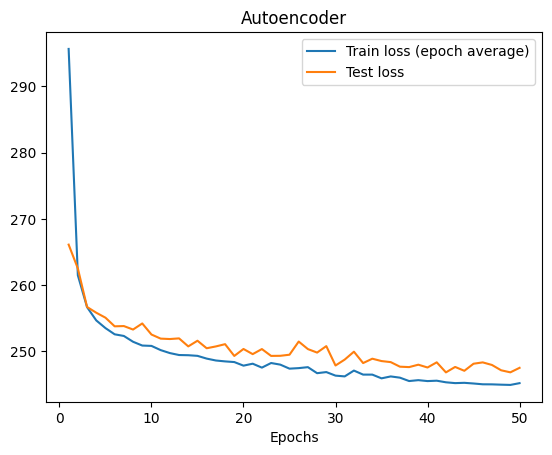

In [6]:
plt.plot(range(1, len(train_loss_history_AE)+1), train_loss_history_AE, label="Train loss (epoch average)")
plt.plot(range(1, len(train_loss_history_AE)+1), test_loss_history_AE, label="Test loss")
plt.legend()
plt.xlabel("Epochs")
plt.title("Autoencoder")
plt.show()

## Train the Variational Autoencoder

In [7]:
print("Training Variational Autoencoder...")
model_VAE = VAE(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim).to(device)
print(model_VAE)
optimizer = torch.optim.AdamW(model_VAE.parameters(), lr=learning_rate)

train_loss_history_VAE = []
test_loss_history_VAE = []
prev_updates = 0
for epoch in range(1, num_epochs + 1):
    print(f'Epoch {epoch}/{num_epochs}')
    prev_updates, train_loss = train(model_VAE, train_loader, optimizer, prev_updates)
    test_loss = test(model_VAE, test_loader)
    train_loss_history_VAE.append(np.mean(train_loss))
    test_loss_history_VAE.append(test_loss)

Training Variational Autoencoder...
Encoder: [Linear(in_features=784, out_features=512, bias=True), LeakyReLU(negative_slope=0.01), Linear(in_features=512, out_features=256, bias=True), LeakyReLU(negative_slope=0.01), Linear(in_features=256, out_features=4, bias=True)]
Decoder: [Linear(in_features=2, out_features=256, bias=True), LeakyReLU(negative_slope=0.01), Linear(in_features=256, out_features=512, bias=True), LeakyReLU(negative_slope=0.01), Linear(in_features=512, out_features=784, bias=True), Sigmoid()]
VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=256, out_features=4, bias=True)
  )
  (softplus): Softplus(beta=1.0, threshold=20.0)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Line

Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 118 (N samples: 60,416), Train set loss: 300.8181


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 273.4471
Epoch 2/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 236 (N samples: 120,832), Train set loss: 268.5530


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 267.3290
Epoch 3/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 354 (N samples: 181,248), Train set loss: 264.5971


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 265.5331
Epoch 4/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 472 (N samples: 241,664), Train set loss: 262.7724


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 264.9454
Epoch 5/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 590 (N samples: 302,080), Train set loss: 261.6468


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 263.2093
Epoch 6/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 708 (N samples: 362,496), Train set loss: 260.5117


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 263.6950
Epoch 7/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 826 (N samples: 422,912), Train set loss: 260.0667


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 261.9448
Epoch 8/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 944 (N samples: 483,328), Train set loss: 259.1424


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 260.5962
Epoch 9/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 1,062 (N samples: 543,744), Train set loss: 259.1181


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 260.9116
Epoch 10/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 1,180 (N samples: 604,160), Train set loss: 258.4690


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 261.0916
Epoch 11/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 1,298 (N samples: 664,576), Train set loss: 258.1214


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 261.5323
Epoch 12/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 1,416 (N samples: 724,992), Train set loss: 257.8308


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 260.0189
Epoch 13/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 1,534 (N samples: 785,408), Train set loss: 257.7660


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 259.2267
Epoch 14/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 1,652 (N samples: 845,824), Train set loss: 257.1511


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 259.5351
Epoch 15/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 1,770 (N samples: 906,240), Train set loss: 257.0413


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 259.4257
Epoch 16/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 1,888 (N samples: 966,656), Train set loss: 257.5396


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 260.4306
Epoch 17/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 2,006 (N samples: 1,027,072), Train set loss: 257.0279


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 259.9128
Epoch 18/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 2,124 (N samples: 1,087,488), Train set loss: 256.9711


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 258.6107
Epoch 19/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 2,242 (N samples: 1,147,904), Train set loss: 256.0709


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 258.3987
Epoch 20/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 2,360 (N samples: 1,208,320), Train set loss: 255.9455


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 259.5597
Epoch 21/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 2,478 (N samples: 1,268,736), Train set loss: 255.9675


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 258.0475
Epoch 22/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 2,596 (N samples: 1,329,152), Train set loss: 255.5233


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 257.4615
Epoch 23/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 2,714 (N samples: 1,389,568), Train set loss: 255.7557


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 257.5202
Epoch 24/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 2,832 (N samples: 1,449,984), Train set loss: 255.8208


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 258.0798
Epoch 25/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 2,950 (N samples: 1,510,400), Train set loss: 255.6252


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 258.6506
Epoch 26/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 3,068 (N samples: 1,570,816), Train set loss: 255.1226


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 258.6058
Epoch 27/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 3,186 (N samples: 1,631,232), Train set loss: 255.2994


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 258.1880
Epoch 28/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 3,304 (N samples: 1,691,648), Train set loss: 256.2777


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 257.9481
Epoch 29/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 3,422 (N samples: 1,752,064), Train set loss: 255.3459


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 258.5500
Epoch 30/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 3,540 (N samples: 1,812,480), Train set loss: 255.3262


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 257.4814
Epoch 31/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 3,658 (N samples: 1,872,896), Train set loss: 255.1498


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 259.5980
Epoch 32/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 3,776 (N samples: 1,933,312), Train set loss: 255.0981


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 258.0648
Epoch 33/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 3,894 (N samples: 1,993,728), Train set loss: 255.0855


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 257.2609
Epoch 34/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 4,012 (N samples: 2,054,144), Train set loss: 254.6852


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 258.2067
Epoch 35/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 4,130 (N samples: 2,114,560), Train set loss: 254.9040


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 259.1137
Epoch 36/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 4,248 (N samples: 2,174,976), Train set loss: 255.6985


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 261.2671
Epoch 37/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 4,366 (N samples: 2,235,392), Train set loss: 256.6158


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 258.7919
Epoch 38/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 4,484 (N samples: 2,295,808), Train set loss: 255.9229


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 258.0433
Epoch 39/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 4,602 (N samples: 2,356,224), Train set loss: 255.7840


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 257.7524
Epoch 40/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 4,720 (N samples: 2,416,640), Train set loss: 255.3350


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 257.5197
Epoch 41/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 4,838 (N samples: 2,477,056), Train set loss: 255.2755


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 257.9357
Epoch 42/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 4,956 (N samples: 2,537,472), Train set loss: 254.8201


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 257.9913
Epoch 43/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 5,074 (N samples: 2,597,888), Train set loss: 254.8249


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 259.5800
Epoch 44/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 5,192 (N samples: 2,658,304), Train set loss: 254.9488


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 257.3083
Epoch 45/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 5,310 (N samples: 2,718,720), Train set loss: 254.7035


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 257.8397
Epoch 46/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 5,428 (N samples: 2,779,136), Train set loss: 254.6080


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 257.1331
Epoch 47/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 5,546 (N samples: 2,839,552), Train set loss: 254.5972


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 257.3207
Epoch 48/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 5,664 (N samples: 2,899,968), Train set loss: 254.4451


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 256.0728
Epoch 49/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 5,782 (N samples: 2,960,384), Train set loss: 254.2283


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 257.1395
Epoch 50/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 5,900 (N samples: 3,020,800), Train set loss: 254.0312


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 256.6503


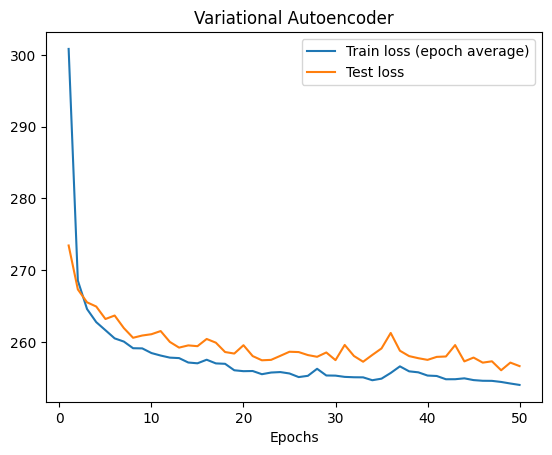

In [8]:
plt.plot(range(1, len(train_loss_history_VAE)+1), train_loss_history_VAE, label="Train loss (epoch average)")
plt.plot(range(1, len(train_loss_history_VAE)+1), test_loss_history_VAE, label="Test loss")
plt.legend()
plt.xlabel("Epochs")
plt.title("Variational Autoencoder")
plt.show()

## Plot functions

In [9]:
def plot_latent_space(model):
    model.eval()
    z_all = []
    y_all = []
    with torch.no_grad():
        for data, target in tqdm(train_loader, desc='Encoding'):
            z = model.encode(data.to(device))
            if isinstance(model, VAE):
                z = z.mean
            z_all.append(z.cpu().numpy())
            y_all.append(target.numpy())

    z_all = np.concatenate(z_all, axis=0)
    y_all = np.concatenate(y_all, axis=0)

    plt.figure(figsize=(10, 10))
    plt.scatter(z_all[:, 0], z_all[:, 1], c=y_all, cmap='tab10')
    plt.xlim(-6,6)
    plt.ylim(-6,6)
    plt.colorbar()
    plt.title(f'Latent projection')
    plt.show()

def plot_random_samples(model):
    model.eval()

    std_normal = torch.distributions.MultivariateNormal(
        torch.zeros(model.latent_dim, device=device),
        covariance_matrix=torch.eye(model.latent_dim, device=device),
    )

    samples = model.decode(std_normal.sample((100,)))

    _, ax = plt.subplots(10, 10, figsize=(10, 10))
    for i in range(10):
        for j in range(10):
            ax[i, j].imshow(samples[i*10+j].view(28, 28).cpu().detach().numpy(), cmap='gray')
            ax[i, j].axis('off')
    plt.show()

## Show plots

Autoencoder:


Encoding:   0%|          | 0/118 [00:00<?, ?it/s]

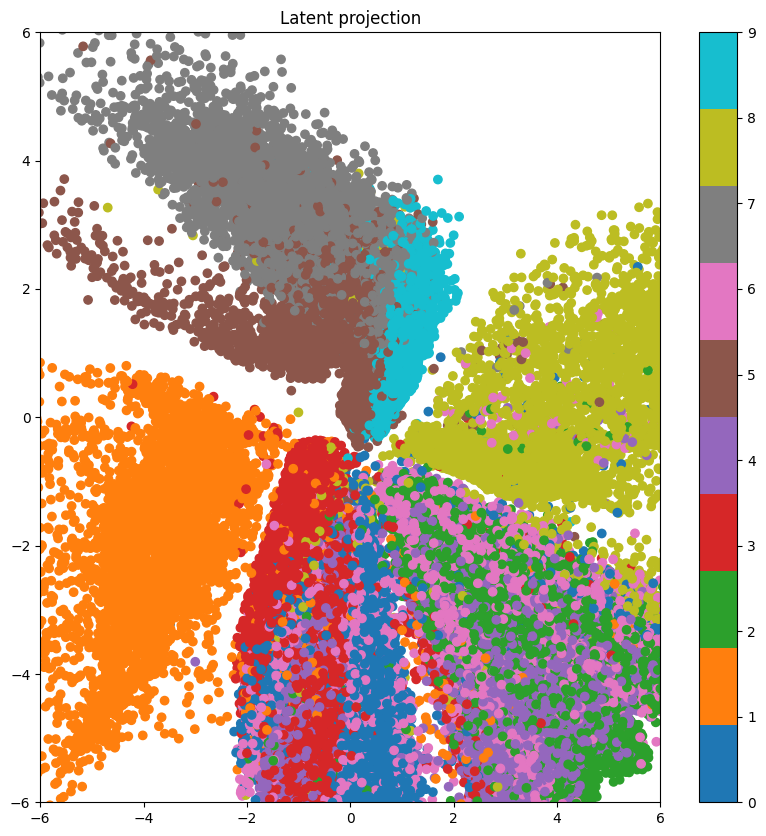

Variational Autoencoder:


Encoding:   0%|          | 0/118 [00:00<?, ?it/s]

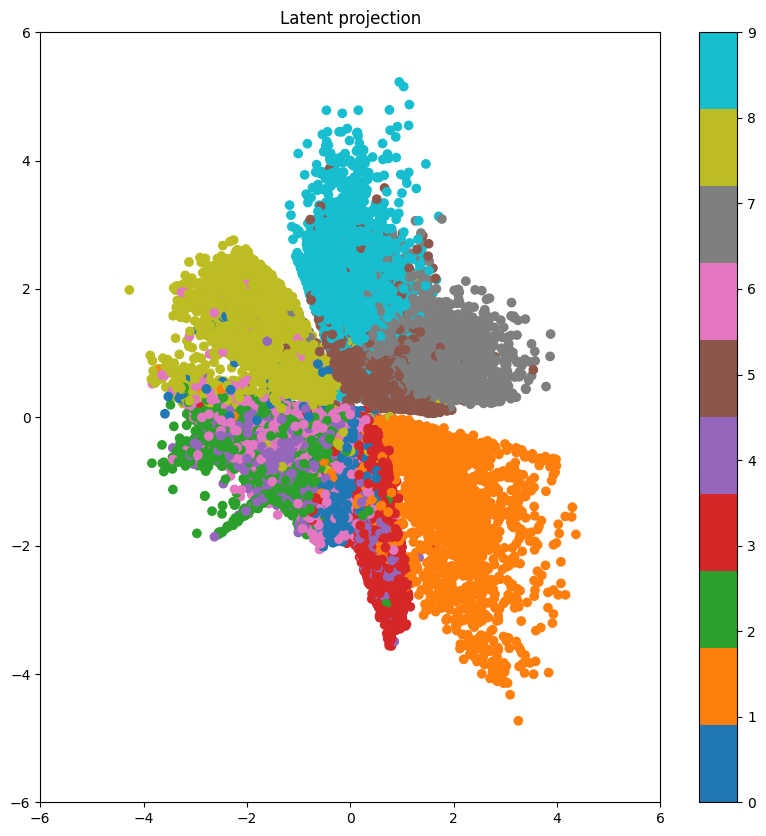

In [10]:
print("Autoencoder:")
plot_latent_space(model_AE)
print("Variational Autoencoder:")
plot_latent_space(model_VAE)

Autoencoder:


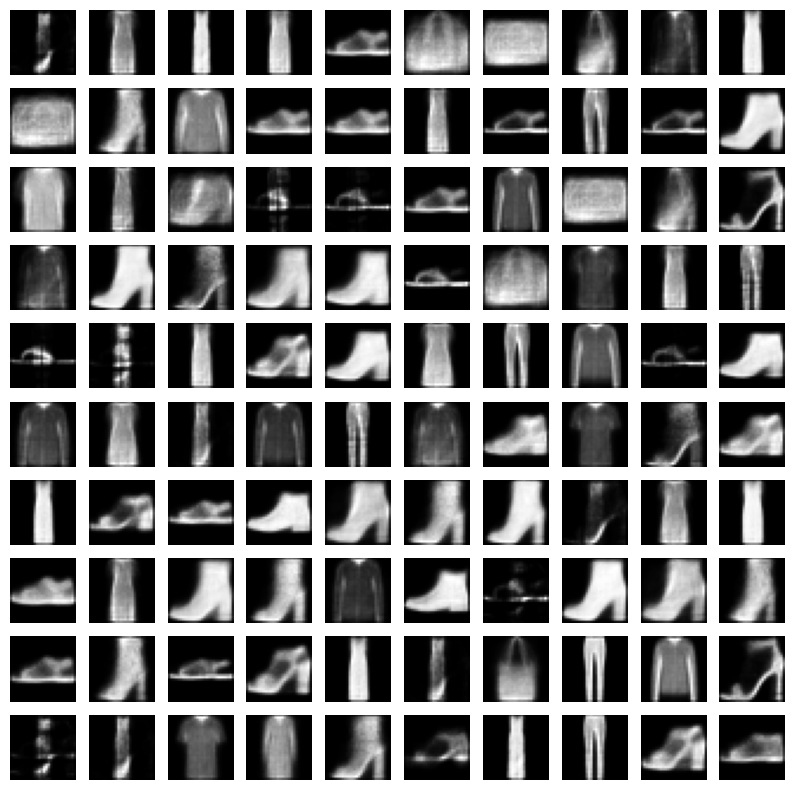

Variational Autoencoder:


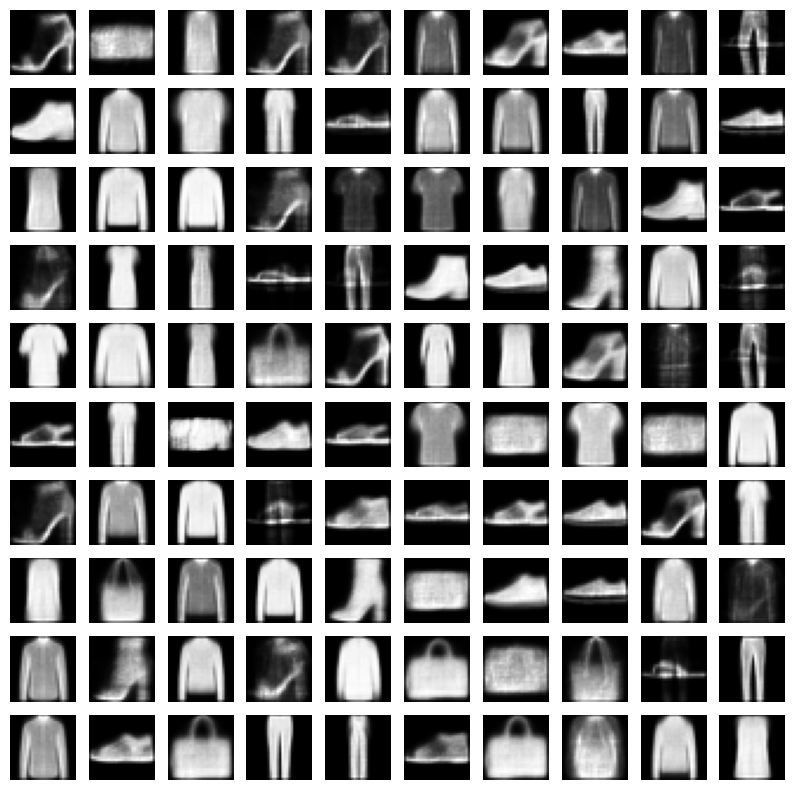

In [11]:
print("Autoencoder:")
plot_random_samples(model_AE)
print("Variational Autoencoder:")
plot_random_samples(model_VAE)